In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch
import lightning as L
from torch import nn
from dal_toolbox.datasets.base import BaseData
from dal_toolbox import metrics
from dal_toolbox.models import deterministic
import warnings
from sklearn.metrics import pairwise_kernels
from torch.utils.data import DataLoader

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data
    
def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
    exp_json = path / 'results.json'
    results = load_json(exp_json)
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def create_hparams_results_path(dataset, encoder, blr=0.075, bs=512, temp=0.1, ssl_model="simclr"):
    path = f"/mnt/stud/home/ynagel/dal-toolbox/results/self_supervised_learning/{dataset}/{ssl_model}_{encoder}/baselr_{blr}_bs_{bs}_temp_{temp}/"
    return Path(path)

path = create_hparams_results_path(dataset="SVHN", encoder="resnet18_deterministic")
print(path)
exp_results = get_experiments(Path(path), "seed*")
print(exp_results[0]["FinalLinearEvaluation"])

/mnt/stud/home/ynagel/dal-toolbox/results/self_supervised_learning/SVHN/simclr_resnet18_deterministic/baselr_0.075_bs_512_temp_0.1
{'final_train_acc': 0.9060077667236328, 'final_val_acc': 0.8879333734512329, 'final_test_acc': 0.8955132365226746}


In [3]:
datasets = ["SVHN", "CIFAR10"] # TODO Add other datasets
encoders = ["resnet18_deterministic", "resnet50_deterministic", "wide_resnet_28_10"]
learning_rates = ["0.025", "0.075", "0.125", "0.175"]
batch_sizes = ["512", "2048"]
temperatures = ["0.1", "0.5"]

encoder_names = {"resnet18_deterministic" : "ResNet18", "resnet50_deterministic" : "ResNet50", "wide_resnet_28_10" : "WideResNet2810"}

resnet18_deterministic 0.025 512 0.1 - 0.8416000008583069
resnet18_deterministic 0.025 512 0.5 - 0.8651999831199646
resnet18_deterministic 0.025 2048 0.1 - 0.8133999705314636
resnet18_deterministic 0.025 2048 0.5 - 0.8185999989509583
resnet18_deterministic 0.075 512 0.1 - 0.8853999972343445
resnet18_deterministic 0.075 512 0.5 - 0.9007999897003174
resnet18_deterministic 0.075 2048 0.1 - 0.8600000143051147
resnet18_deterministic 0.075 2048 0.5 - 0.8533999919891357
resnet18_deterministic 0.125 512 0.1 - 0.8859999775886536
resnet18_deterministic 0.125 512 0.5 - 0.9049999713897705
resnet18_deterministic 0.125 2048 0.1 - 0.8622000217437744
resnet18_deterministic 0.125 2048 0.5 - 0.8610000014305115
resnet18_deterministic 0.175 512 0.1 - 0.8845999836921692
resnet18_deterministic 0.175 512 0.5 - 0.9075999855995178
resnet18_deterministic 0.175 2048 0.1 - 0.8574000000953674
resnet18_deterministic 0.175 2048 0.5 - 0.8626000285148621
resnet50_deterministic 0.025 512 0.1 - 0.8741999864578247
resnet

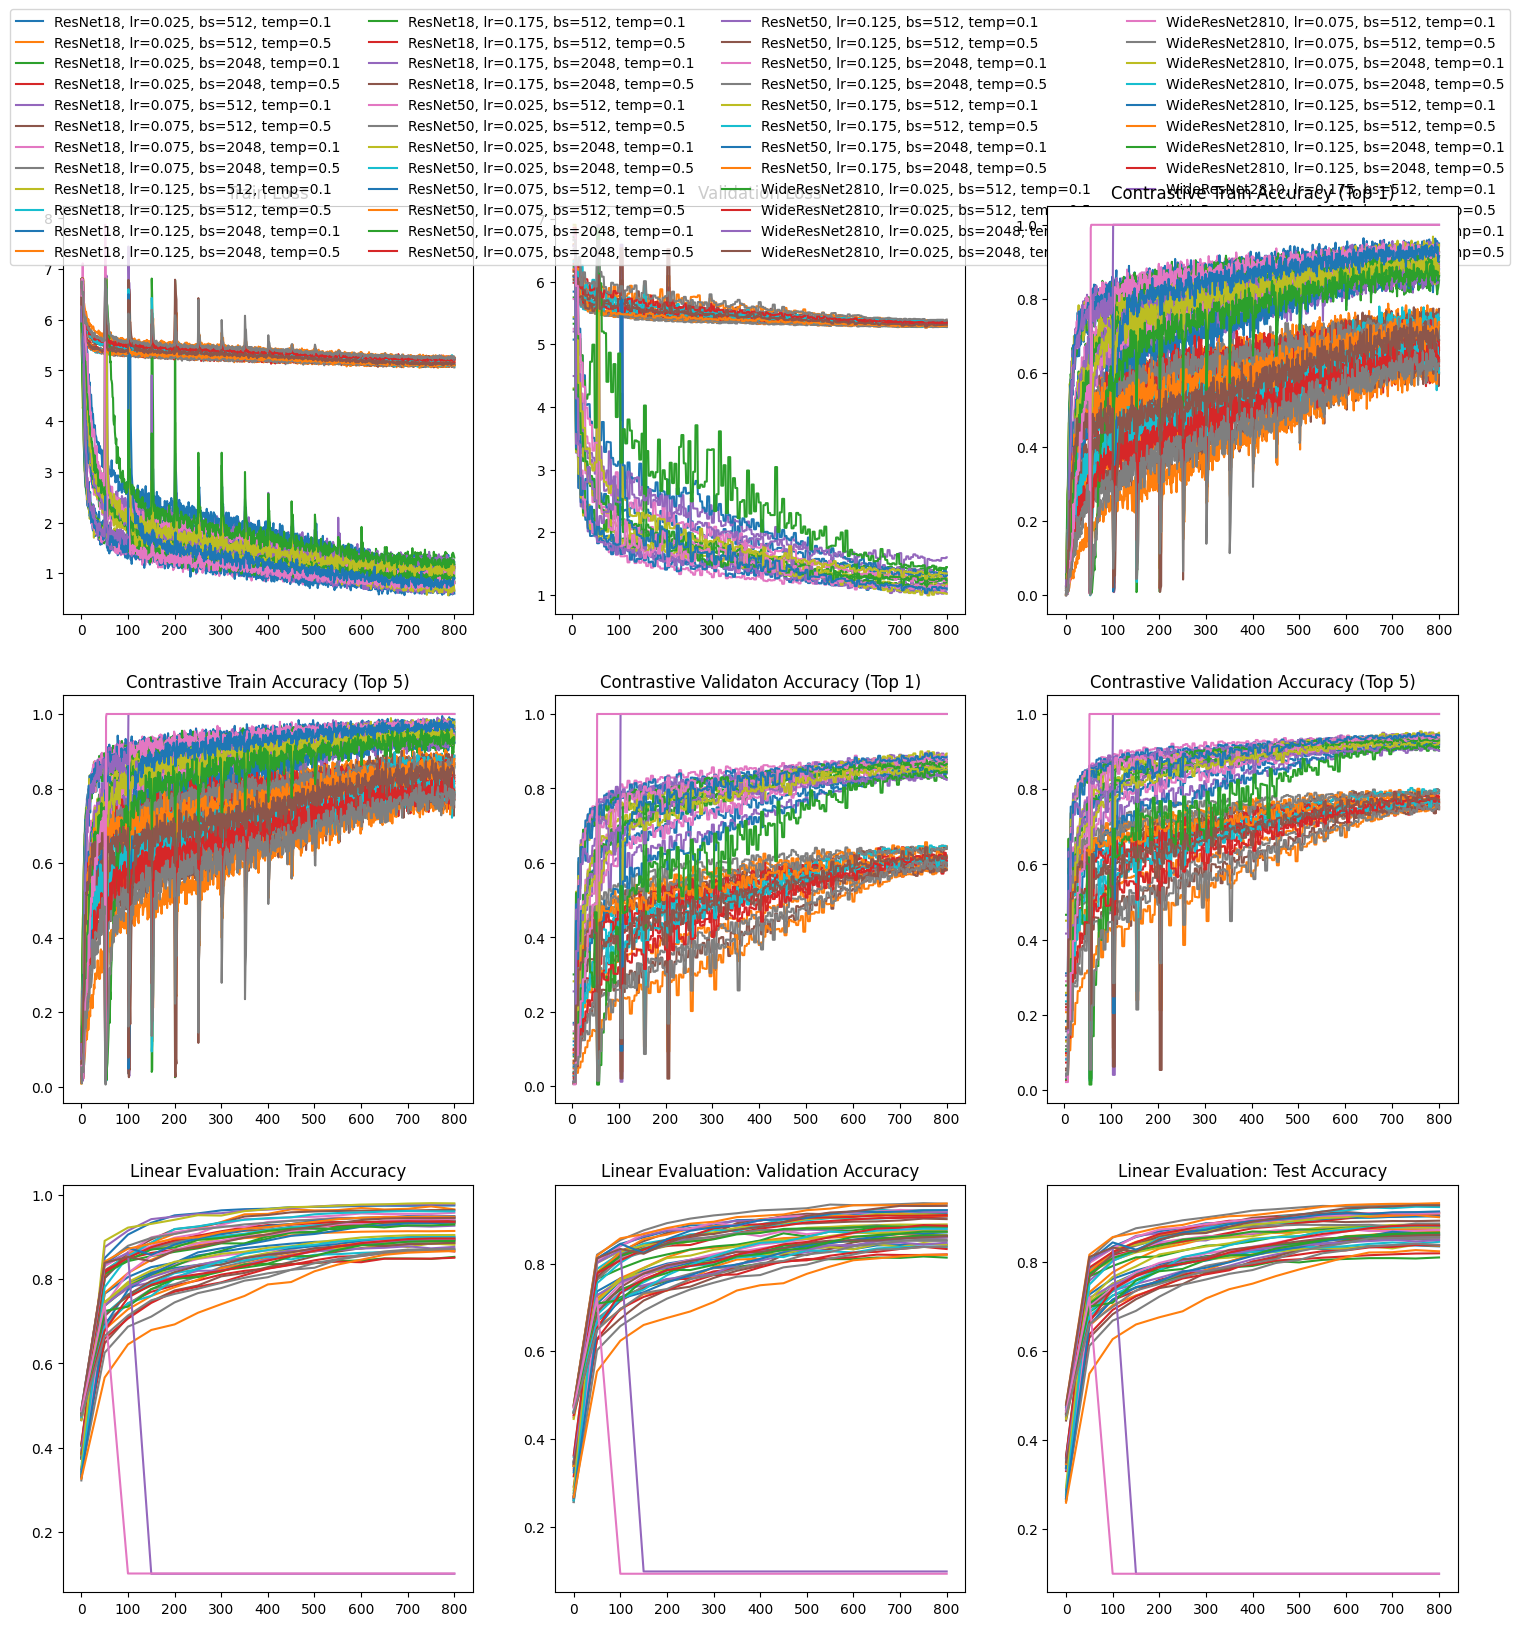

In [5]:
def plot_hparams_results(result_list, leg_cols=4):
    fig, axis = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))

    for result in result_list:
        x_axis = np.arange(0, len(result["SimCLR"]["train_loss"]))
        axis[0, 0].plot(x_axis, result["SimCLR"]["train_loss"])
        axis[0, 0].set_title("Train Loss")
        axis[0, 1].plot(x_axis, result["SimCLR"]["val_loss"], label=result["name"])
        axis[0, 1].set_title("Validation Loss")

        axis[0, 2].plot(x_axis, result["SimCLR"]["train_acc_top1"])
        axis[0, 2].set_title("Contrastive Train Accuracy (Top 1)")
        axis[1, 0].plot(x_axis, result["SimCLR"]["train_acc_top5"])
        axis[1, 0].set_title("Contrastive Train Accuracy (Top 5)")
        axis[1, 1].plot(x_axis, result["SimCLR"]["val_acc_top1"])
        axis[1, 1].set_title("Contrastive Validaton Accuracy (Top 1)")
        axis[1, 2].plot(x_axis, result["SimCLR"]["val_acc_top5"])
        axis[1, 2].set_title("Contrastive Validation Accuracy (Top 5)")

        x_axis = np.arange(0, len(result["SimCLR"]["train_loss"]), step=result["LinearEvaluation"]["interval"])
        axis[2, 0].plot(x_axis, result["LinearEvaluation"]["final_train_acc"])
        axis[2, 0].set_title("Linear Evaluation: Train Accuracy")
        axis[2, 1].plot(x_axis, result["LinearEvaluation"]["final_val_acc"])
        axis[2, 1].set_title("Linear Evaluation: Validation Accuracy")
        axis[2, 2].plot(x_axis, result["LinearEvaluation"]["final_test_acc"])
        axis[2, 2].set_title("Linear Evaluation: Test Accuracy")

    axis[0, 1].legend(loc="upper center", ncols=leg_cols, bbox_to_anchor=(0.5, 1.5))
    plt.show()

cifar10_iter_hparams = itertools.product(encoders, learning_rates, batch_sizes, temperatures)
cifar10_result_list = []
for encoder, lr, bs, temp  in cifar10_iter_hparams:
    print(encoder, lr, bs, temp, end=" - ")
    try:
        path = create_hparams_results_path(dataset="CIFAR10", encoder=encoder, blr=lr, bs=bs, temp=temp)
        dct = get_experiments(Path(path), "seed*")[0]
        dct["name"] =  f"{encoder_names[encoder]}, lr={lr}, bs={bs}, temp={temp}"
        dct["encoder"] =  encoder
        dct["lr"] =  lr
        dct["bs"] =  bs
        dct["temp"] =  temp
        print(dct["FinalLinearEvaluation"]["final_val_acc"])
        cifar10_result_list.append(dct)
    except FileNotFoundError:
        print("Missing")

plot_hparams_results(cifar10_result_list)

In [6]:
cifar10_iter_hparams = itertools.product(encoders, learning_rates, temperatures)
for encoder, lr, temp  in cifar10_iter_hparams:
    bs512 = None
    bs2048 = None
    for element in cifar10_result_list:
        if element["encoder"] == encoder and element["lr"] == lr and element["temp"] == temp:
            if element["bs"] == "512":
                bs512 = element
            if element["bs"] == "2048":
                bs2048 = element

    print(f'{bs512["FinalLinearEvaluation"]["final_val_acc"]:.3f} vs. {bs2048["FinalLinearEvaluation"]["final_val_acc"]:.3f} --> Difference: {(bs512["FinalLinearEvaluation"]["final_val_acc"] - bs2048["FinalLinearEvaluation"]["final_val_acc"]):.3f}')

0.842 vs. 0.813 --> Difference: 0.028
0.865 vs. 0.819 --> Difference: 0.047
0.885 vs. 0.860 --> Difference: 0.025
0.901 vs. 0.853 --> Difference: 0.047
0.886 vs. 0.862 --> Difference: 0.024
0.905 vs. 0.861 --> Difference: 0.044
0.885 vs. 0.857 --> Difference: 0.027
0.908 vs. 0.863 --> Difference: 0.045
0.874 vs. 0.840 --> Difference: 0.034
0.887 vs. 0.838 --> Difference: 0.048
0.915 vs. 0.863 --> Difference: 0.051
0.907 vs. 0.837 --> Difference: 0.070
0.919 vs. 0.878 --> Difference: 0.041
0.918 vs. 0.835 --> Difference: 0.083
0.912 vs. 0.870 --> Difference: 0.042
0.919 vs. 0.821 --> Difference: 0.098
0.885 vs. 0.844 --> Difference: 0.041
0.909 vs. 0.861 --> Difference: 0.047
0.917 vs. 0.874 --> Difference: 0.043
0.936 vs. 0.877 --> Difference: 0.059
0.921 vs. 0.874 --> Difference: 0.047
0.937 vs. 0.886 --> Difference: 0.052
0.098 vs. 0.093 --> Difference: 0.005
0.929 vs. 0.855 --> Difference: 0.074


Best CIFAR10 Result: WideResNet2810, lr=0.125, bs=512, temp=0.5 --> Train Accuracy: 0.947, Validation Accuracy: 0.937, Test Accuracy: 0.933


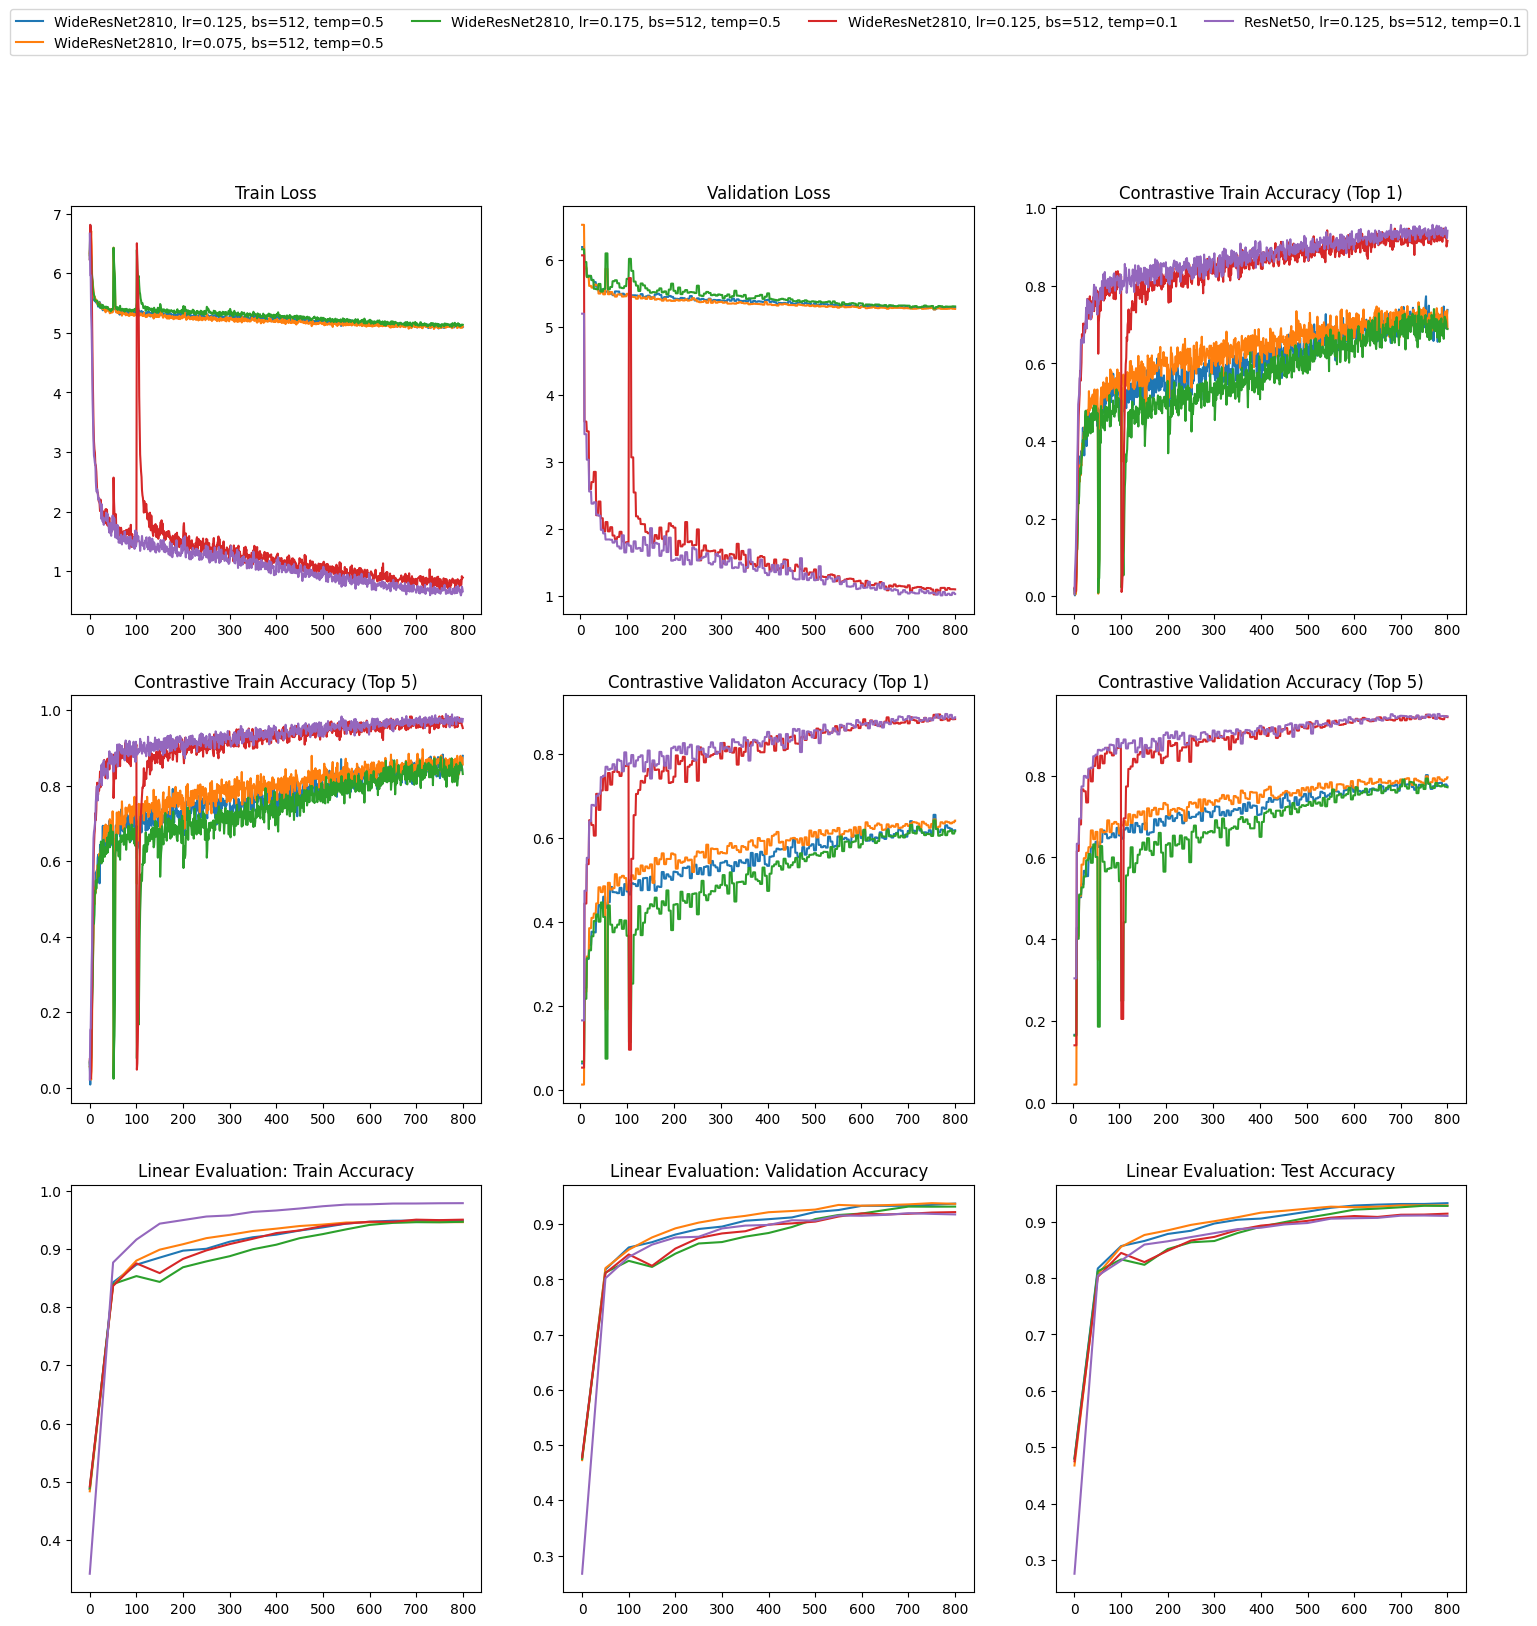

In [7]:
def get_top_x_from_results_list(lst, topk=5):
    return sorted(lst, key=lambda x: x["FinalLinearEvaluation"]["final_val_acc"], reverse=True)[:topk]
    

sorted_cifar10_results_list = get_top_x_from_results_list(cifar10_result_list, topk=5)
best_cifar10_result = sorted_cifar10_results_list[0]
print(f"Best CIFAR10 Result: {best_cifar10_result['name']} --> Train Accuracy: {best_cifar10_result['FinalLinearEvaluation']['final_train_acc']:.3f}, "
                                                        f"Validation Accuracy: {best_cifar10_result['FinalLinearEvaluation']['final_val_acc']:.3f}, "
                                                        f"Test Accuracy: {best_cifar10_result['FinalLinearEvaluation']['final_test_acc']:.3f}")
plot_hparams_results(sorted_cifar10_results_list)

In [8]:
class FeatureDatasetWrapper(BaseData):
    """
    Wrapper for FeatureDatasets to be used with AbstractData
    """

    def __init__(self, dataset_path):
        super().__init__(dataset_path)

    @property
    def num_classes(self):
        return self.n_classes

    @property
    def num_features(self):
        return self.n_features

    def download_datasets(self):
        map = "cpu" if not torch.cuda.is_available() else None
        feature_dict = torch.load(self.dataset_path, map_location=map)
        self._trainset = feature_dict["trainset"]
        self._testset = feature_dict["testset"]
        self.n_classes = len(torch.unique(self._testset.labels))
        self.n_features = self._testset.features.shape[1]

    @property
    def full_train_dataset_eval_transforms(self):
        warnings.warn("FeatureDataset hast no EvalTransforms")
        return self.full_train_dataset

    @property
    def full_train_dataset_query_transforms(self):
        warnings.warn("FeatureDataset hast no QueryTransform")
        return self.full_train_dataset

    @property
    def test_dataset(self):
        return self._testset

    @property
    def train_transforms(self):
        return None

    @property
    def query_transforms(self):
        return None

    @property
    def eval_transforms(self):
        return None

    @property
    def full_train_dataset(self):
        return self._trainset

def _calculate_mean_gamma(data, delta=(np.sqrt(2) * 1e-6)):
    N = data.shape[0]
    n_features = data.shape[1]
    variance = torch.var(data, dim=0).numpy()

    denominator = 2 * N * np.sum(variance)
    numerator = (N - 1) * np.log((N - 1) / delta ** 2)
    if denominator <= 0:
        gamma = 1 / n_features
    else:
        gamma = 0.5 * numerator / denominator
    return float(gamma)

def kernels(X, Y, metric, **kwargs):
    metric = str(metric)
    if metric == 'rbf':
        gamma = kwargs.pop('gamma')
        return pairwise_kernels(X=X, Y=Y, metric=metric, gamma=gamma)
    elif metric == 'cosine':
        return pairwise_kernels(X=X, Y=Y, metric=metric)
    elif metric == 'angular':
        return 1 - np.arccos(np.clip(pairwise_kernels(X=X, Y=Y, metric="cosine"), -1.0, 1.0)) / np.pi
    elif metric == 'categorical':
        gamma = kwargs.pop('gamma')
        return np.exp(-gamma * cdist(XA=X, XB=Y, metric='hamming'))

best_paths = create_hparams_results_path(dataset="CIFAR10", encoder=best_cifar10_result['encoder'], blr=best_cifar10_result['lr'], bs=best_cifar10_result['bs'], temp=best_cifar10_result['temp']).glob("seed*")
for i, best_path in enumerate(best_paths): # Should only be one
    assert i == 0, "Shoudl only be one best path"
    best_path = Path(str(best_path) +  f"/{best_cifar10_result['encoder']}_CIFAR10_{best_cifar10_result['FinalLinearEvaluation']['final_val_acc']:.3f}.pth")
    cifar10_data = FeatureDatasetWrapper(best_path)

In [9]:
import sys
trainset = cifar10_data.train_dataset
features = torch.stack([batch[0] for batch in trainset])
gamma = _calculate_mean_gamma(features)
print(f"Calculated gamma: {gamma}")
S = kernels(X=features, Y=features, metric="rbf", gamma=gamma)
print(f"Shape of S: {S.shape}, Memory Usage: {sys.getsizeof(S) * 1e-09} GB")
np.fill_diagonal(S, np.nan)

mean=np.nanmean(S)
median=np.nanmedian(S)
quantile_25=np.nanquantile(S, 0.25)
quantile_75=np.nanquantile(S, 0.75)

print(f"Mean similarity: {mean}")
print(f"Median similarity: {median}")
print(f"Min similarity: {np.nanmin(S)}")
print(f"Max similarity: {np.nanmax(S)}")
print(f"0.25-Quantile similarity: {quantile_25}")
print(f"0.75-Quantile: {quantile_75}")

Calculated gamma: 0.35400470389899186
Shape of S: (45000, 45000), Memory Usage: 8.100000128000001 GB
Mean similarity: 0.0018831684719771147
Median similarity: 3.233247412026685e-07
Min similarity: 0.0
Max similarity: 0.9629077315330505
0.25-Quantile similarity: 2.6960019286481618e-11
0.75-Quantile: 9.417432738700882e-05


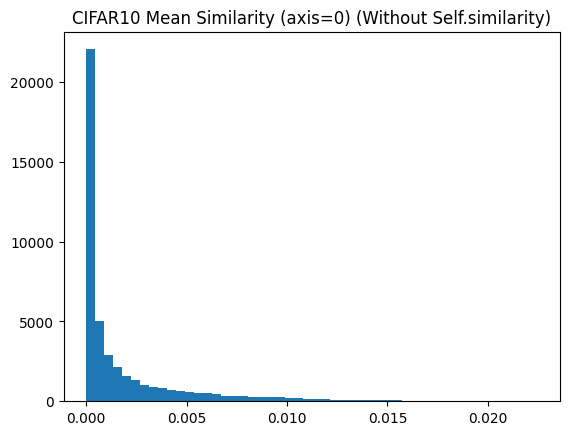

In [10]:
plt.hist(np.nanmean(S, axis=0), bins=50)
plt.title("CIFAR10 Mean Similarity (axis=0) (Without Self.similarity)")
plt.show()

(10000, 10000)
1.000e+08 Elements in matrix


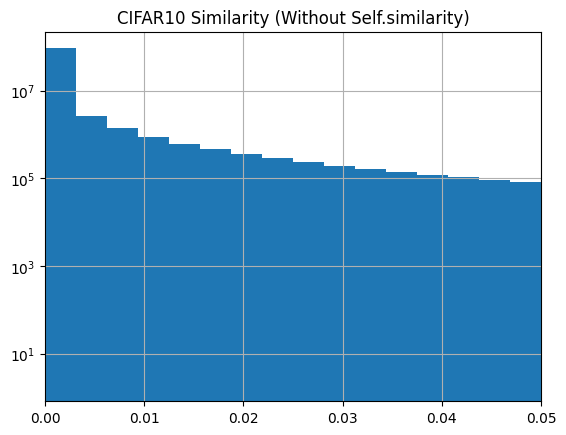

In [11]:
idx = np.random.randint(0, 45000, 10000)

slice = S[idx]
slice = slice[:, idx]
print(slice.shape)
print(f"{slice.shape[0] * slice.shape[1]:.3e} Elements in matrix")

plt.hist(slice.flat, bins=300)
plt.title("CIFAR10 Similarity (Without Self.similarity)")
plt.yscale("log")
plt.xlim(0, 0.05)
plt.grid(True)
# plt.vlines([mean, median, quantile_25, quantile_75], ymin=0, ymax=10**7)
plt.show()

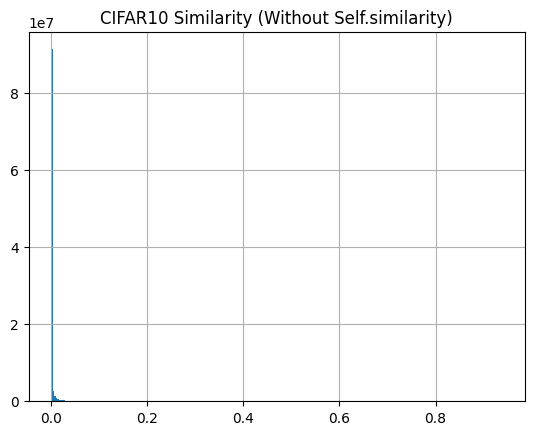

In [12]:
plt.hist(slice.flat, bins=300)
plt.title("CIFAR10 Similarity (Without Self.similarity)")
plt.grid(True)
# plt.vlines([mean, median, quantile_25, quantile_75], ymin=0, ymax=10**7)
plt.show()

In [9]:
from dal_toolbox.datasets.svhn import SVHNPlain

class EncoderDataset(Dataset):
    def __init__(self, subset, encoder, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

def custom_collate(batch):
    batch = torch.utils.data.default_collate(batch)
    return encoder(batch[0]), batch[1]

cifar = SVHNPlain("/mnt/stud/home/ynagel/data/")
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
])

train_dataloader = DataLoader(EncoderDataset(cifar.train_dataset, encoder, transform),
                                   batch_size=256,
                                   shuffle=True,
                             collate_fn=custom_collate)

val_dataloader = DataLoader(EncoderDataset(cifar.val_dataset, encoder, None),
                                 batch_size=256,
                                 shuffle=False,
                           collate_fn=custom_collate)

test_dataloader = DataLoader(EncoderDataset(cifar.test_dataset, encoder, None),
                                  batch_size=256,
                                  shuffle=False,
                            collate_fn=custom_collate)

model = nn.Linear(2048, 10)

optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.01,
                            weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
model = deterministic.DeterministicModel(
    model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    train_metrics={'train_acc': metrics.Accuracy()},
    val_metrics={'val_acc': metrics.Accuracy()},
)

trainer = L.Trainer(
    default_root_dir="~/tmp",
    accelerator="auto",
    max_epochs=100,
    enable_checkpointing=False,
    check_val_every_n_epoch=10,
    enable_progress_bar=True,
)

trainer.fit(model, train_dataloader, val_dataloader)

NameError: name 'Dataset' is not defined

In [ ]:
import torch
from torch import nn
from dal_toolbox.models import deterministic

path = "/mnt/work/deep_al/simclr_mdoels/wide_resnet_28_10_CIFAR10_0.907.pth"
results = torch.load(path, map_location=torch.device('cpu')) # Can be gpu if one available

print(results.keys()) # dict_keys(['trainset', 'testset', 'model'])

# Build Encoder
encoder = deterministic.wide_resnet.wide_resnet_28_10(num_classes=1, dropout_rate=0.3) # All are currently widerresnets, but would have to change if different model
encoder.linear = nn.Identity()
encoder.load_state_dict(results["model"])